# Matrix Factorization with Bias

Similar to 09_matrix_factorization.py, but with user and item bias (TODO: Add reference on why this bias is needed).

## Reference:
- https://github.com/GabrielSandoval/matrix_factorization/blob/master/lib/mf.py
- https://d2l.ai/chapter_recommender-systems/mf.html
- https://medium.com/@maxbrenner-ai/matrix-factorization-for-collaborative-filtering-linear-to-non-linear-models-in-python-5cf54363a03c

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape
embedding_dim = 10
U = np.random.normal(size=(num_users, embedding_dim))
V = np.random.normal(size=(num_items, embedding_dim))

# Initialize user and item bias vectors
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

# Initialize global bias
global_bias = 0.0

# Define the learning rate and regularization strength
lr = 0.01
reg_strength = 1e-5
losses = []

# Define the loss function
def mse_loss(U, V, user_bias, item_bias, global_bias, R):
    prediction = U @ V.T + user_bias[:, None] + item_bias[None, :] + global_bias
    mask = R > 0
    num_ratings = np.sum(mask)
    loss = np.sum((R - prediction) ** 2 * mask) / num_ratings
    # Add regularization
    loss += reg_strength * (
        np.sum(U ** 2)
        + np.sum(V ** 2)
        + np.sum(user_bias ** 2)
        + np.sum(item_bias ** 2)
        + global_bias ** 2
    )
    return loss


# Run the optimization
for i in range(500):
    R_hat = U @ V.T + user_bias[:, None] + item_bias[None, :] + global_bias
    mask = R > 0
    num_ratings = np.sum(mask)
    error = (R - R_hat) * mask

    # Compute gradients
    grad_U = -2 * error @ V / num_ratings + 2 * reg_strength * U
    grad_V = -2 * error.T @ U / num_ratings + 2 * reg_strength * V
    grad_user_bias = (
        -2 * np.sum(error, axis=1) / num_ratings + 2 * reg_strength * user_bias
    )
    grad_item_bias = (
        -2 * np.sum(error, axis=0) / num_ratings + 2 * reg_strength * item_bias
    )
    grad_global_bias = -2 * np.sum(error) / num_ratings + 2 * reg_strength * global_bias

    # Update parameters
    U -= lr * grad_U
    V -= lr * grad_V
    user_bias -= lr * grad_user_bias
    item_bias -= lr * grad_item_bias
    global_bias -= lr * grad_global_bias

    loss = mse_loss(U, V, user_bias, item_bias, global_bias, R)
    if i % 100 == 0:
        print("Iteration", i, "Loss", loss)
    losses.append(loss)

Iteration 0 Loss 16.323813467839333
Iteration 100 Loss 0.2256325909365729
Iteration 200 Loss 0.006351976203438983
Iteration 300 Loss 0.0009863730760844933
Iteration 400 Loss 0.0008500977701662314


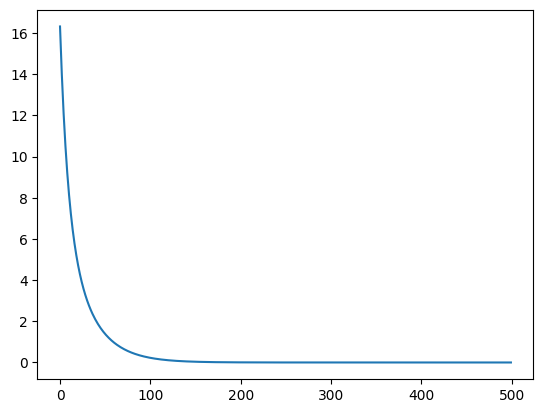

In [3]:
plt.plot(losses)

In [4]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [5]:
print("Reconstructed ratings:")
R_hat = (
    np.round(U @ V.T, 2)
    + user_bias[:, np.newaxis]
    + item_bias[np.newaxis, :]
    + global_bias
)
print(R_hat)

Reconstructed ratings:
[[ 5.00239928  2.99849835  1.64959632  1.00543805]
 [ 3.99931197  1.94541103  1.90650901  1.00235074]
 [ 0.99722481  1.00332388 -2.96557814  5.00026359]
 [ 0.99549645 -1.98840448  1.59269349  3.99853522]
 [ 5.51346806  0.99956713  5.00066511  3.99650684]]


### Output

In [6]:
# If the replace does not work, check if the data type for R matches R_hat, which is float.
# If the data type of the matrix to replace does not match, it will silently failed.
mask = R == 0
R[mask] = R_hat[mask]
np.maximum(np.round(R, 1), 0)

array([[5. , 3. , 1.6, 1. ],
       [4. , 1.9, 1.9, 1. ],
       [1. , 1. , 0. , 5. ],
       [1. , 0. , 1.6, 4. ],
       [5.5, 1. , 5. , 4. ]], dtype=float32)

## Using Keras

The `tf.reduce_sum` function is used in the loss function to sum up all the individual squared differences between the actual ratings and the predicted ratings.

In the context of matrix factorization, the goal is to find the user and item embeddings that minimize the total (or sum of) squared differences between the actual and predicted ratings. This is known as the Mean Squared Error (MSE) loss, and it's a common choice for regression problems.

The `tf.reduce_sum` function is used instead of `tf.reduce_mean` because we're only considering non-zero entries in the ratings matrix (i.e., the user-item pairs where a rating is available). The number of such entries is not fixed (it depends on the sparsity of the ratings matrix), so it's simpler to sum up all the squared differences and let the optimizer find the minimum of this sum.

If you were to use `tf.reduce_mean`, you would need to divide by the number of non-zero entries, which would add an extra step to the computation. The optimizer would still be able to find the minimum of the mean loss, but the loss values reported during training would be smaller by a factor equal to the number of non-zero entries.

In [7]:
import tensorflow as tf

R = tf.constant(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=tf.float32,
)
n_user, n_item = R.shape
K = min(R.shape) - 2


U = tf.Variable(tf.random.normal([n_user, K], stddev=0.1))
V = tf.Variable(tf.random.normal([n_item, K], stddev=0.1))

N = n_user * n_item


b = tf.Variable(tf.math.reduce_mean(R[tf.math.not_equal(R, 0)]), name="global_bias")
b_u = tf.Variable(tf.zeros(n_user), name="user_bias")
b_i = tf.Variable(tf.zeros(n_item), name="item_bias")

T = 500  # Epochs
alpha = 0.01  # learning rate
beta = 1e-5

trainable_weights = [U, V, b, b_u, b_i]
optimizer = tf.keras.optimizers.SGD(learning_rate=alpha, weight_decay=beta)
losses = []

# Define the loss function
def mse_loss(U, V, b, b_u, b_i, R):
    R_hat = tf.matmul(U, V, transpose_b=True) + b_u[:, None] + b_i[None, :] + b

    # non_zero_mask = tf.math.not_equal(tf.reshape(R, [-1]), 0)
    # indices = tf.where(non_zero_mask)
    # loss = tf.keras.metrics.mean_squared_error(
    #     tf.gather(tf.reshape(R, [-1]), indices),
    #     tf.gather(tf.reshape(R_hat, [-1]), indices),
    # )
    # return loss
    # num_ratings = tf.reduce_sum(tf.cast(non_zero_mask, tf.float32))
    # loss = tf.reduce_sum(tf.square(R - R_hat) * tf.cast(non_zero_mask, tf.float32))
    # return tf.divide(loss, num_ratings)
    # We are not using the mean.
    # This changes the scale of the loss values and the gradients, but doesn't fundamentally change the optimization problem.
    non_zero_mask = tf.math.not_equal(R, 0)
    loss = tf.reduce_sum(tf.square(R - R_hat) * tf.cast(non_zero_mask, tf.float32))
    return loss


for t in range(T):
    with tf.GradientTape() as tape:
        # We rely on automatic differentiation to calculate the gradient loss.
        loss = mse_loss(U, V, b, b_u, b_i, R)
    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    losses.append(tf.reduce_mean(loss).numpy())

    if t % 100 == 0:
        print(t, tf.reduce_mean(loss).numpy())

2024-01-29 00:10:30.236418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 38.623
100 0.22831184
200 0.014539467
300 0.00089419173
400 5.4037977e-05


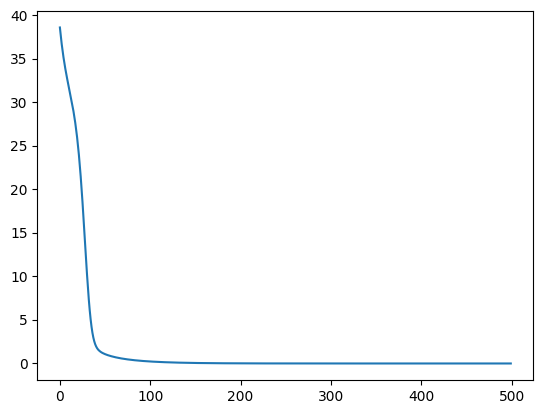

In [8]:
plt.plot(losses)

In [9]:
R_hat = (tf.matmul(U, V, transpose_b=True) + b_u[:, None] + b_i[None, :] + b).numpy()
R = R.numpy()

In [10]:
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

### Reconstructed Ratings

In [11]:
np.round(R_hat, 2)

array([[5.  , 3.  , 4.49, 1.  ],
       [4.  , 2.25, 4.12, 1.  ],
       [1.  , 1.  , 5.5 , 5.  ],
       [1.  , 0.74, 4.87, 4.  ],
       [1.34, 1.  , 5.  , 4.  ]], dtype=float32)

In [12]:
mask = R == 0
R[mask] = R_hat[mask]
np.round(R, 1)

array([[5. , 3. , 4.5, 1. ],
       [4. , 2.2, 4.1, 1. ],
       [1. , 1. , 5.5, 5. ],
       [1. , 0.7, 4.9, 4. ],
       [1.3, 1. , 5. , 4. ]], dtype=float32)

### Output

In [13]:
# We still have issue with negative values, and some values goes beyond 5.
np.round(np.clip(R, 0, 5), 1)

array([[5. , 3. , 4.5, 1. ],
       [4. , 2.2, 4.1, 1. ],
       [1. , 1. , 5. , 5. ],
       [1. , 0.7, 4.9, 4. ],
       [1.3, 1. , 5. , 4. ]], dtype=float32)